# 메서드 정의

### L1: URL, header, API KEY, raw data

In [2]:
from jwt import JWT, jwk
import hashlib
import requests
import uuid

from urllib.parse import urlencode, unquote
import urllib.parse as url_parser

import json
import pandas as pd

from collections import namedtuple

from typing import Literal

from datetime import datetime, timedelta

UrlComponents = namedtuple(typename="UrlComponents", field_names=["scheme", "netloc", "url", "params", "query", "fragment"])

#### Duration class

In [41]:
Duration_datetime = namedtuple(typename="Duration", field_names=["start", "end", "interval"])
Duration_string = namedtuple(typename="Duration_string", field_names=["start", "end"])


class Duration():
    def __init__(self, start: str, end: str, interval: Literal["DAY", "HOUR", "MONTH"]="DAY", _format: str="%Y%m%d"):
        start_dt = datetime.strptime(start, _format)
        end_dt = datetime.strptime(end, _format)

        if interval == "MONTH":
            self.period_id = "1MTH"
            interval_dt = timedelta(days=30)
        elif interval == "HOUR":
            self.period_id = "1HRS"
            interval_dt = timedelta(hours=1)
        else:
            self.period_id = "1DAY"
            interval_dt = timedelta(days=1)

        self.duration = Duration_datetime(start_dt, end_dt, interval_dt)
    
    def strftime(self, timezone=False) -> Duration_string:
        duration = self.duration
        start, end = duration.start.isoformat().split('.')[0], duration.end.isoformat().split('.')[0],

        if timezone:
            start += "+09:00"
            end += "+09:00"        

        result = Duration_string(
            start=start,
            end=end,
        )

        return result


#### URL Generator

In [37]:
def generate_url(source: Literal["upbit", "coinapi"], api_name: Literal["show_account", "order_available", "make_order", "market_code", "BTC_candle"], query: dict|None=None) -> str:
    """
    API 호출을 위한 URL을 생성하는 메서드입니다.

    generates URL for calling API.
    
    Parameters
    ----------
    source : Literal["upbit", "coinapi"]
        호출할 API의 소스를 지정합니다.

    api_name : Literal["show_account", "order_available", "make_order", "market_code", "BTC_candle"]
        호출할 API의 종류를 지정합니다.

    query : dict|None=None
        호출할 API에 들어갈 질의를 지정합니다.
    
    
    Raises
    ------
    ValueError
        부적절한 파라미터가 전달되었을 때 발생합니다.


    Returns
    -------
    result_url
        생성된 URL 문자열    
    """


    # URL 자료 구조 정의
    URL_SOURCES = {
        "upbit": "api.upbit.com",
        "coinapi": "rest.coinapi.io",
    }

    URL_PATHS = {
        "show_account": "v1/accounts",
        "order_available": "v1/orders/chance",
        "make_order": "v1/orders",
        "market_code": "v1/orders/chance",
        "BTC_candle": "v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history",

    }

    SUPPORTED_API_NAMES = URL_PATHS.keys()
    SUPPORTED_SOURCES = URL_SOURCES.keys()

    # 파라미터 검증
    if source not in SUPPORTED_SOURCES:
        raise ValueError(f'source must be "upbit" or "coinapi". input is {source}')
    
    if api_name not in SUPPORTED_API_NAMES:
        raise ValueError(f'api_name {source} not found in supported api_name.')
    
    query = "" if query is None else url_parser.urlencode(query)

    url_params = UrlComponents(
        scheme = "https",
        netloc = URL_SOURCES[source],
        url = URL_PATHS[api_name],
        params = "",
        query = query,
        fragment = "",
    )

    result_url = url_parser.urlunparse(url_params)
    return result_url


#### Query Generator

In [8]:
def generate_query(**params: str) -> dict[str: str]:
    '''
    period_id:
        Second	1SEC, 2SEC, 3SEC, 4SEC, 5SEC, 6SEC, 10SEC, 15SEC, 20SEC, 30SEC
        Minute	1MIN, 2MIN, 3MIN, 4MIN, 5MIN, 6MIN, 10MIN, 15MIN, 20MIN, 30MIN
        Hour	1HRS, 2HRS, 3HRS, 4HRS, 6HRS, 8HRS, 12HRS
        Day	1DAY, 2DAY, 3DAY, 5DAY, 7DAY, 10DAY
        Month	1MTH, 2MTH, 3MTH, 4MTH, 6MTH
        Year	1YRS, 2YRS, 3YRS, 4YRS, 5YRS
    '''

    query = {i:params[i] for i in params}    
    return query


#### API Key Generator

In [38]:
def get_api_key(source: Literal["upbit", "coinapi"]) -> tuple[str, jwk.OctetJWK]|str:
    """
    API 호출을 위한 key를 제공하는 메서드입니다.

    provides API keys for calling API.
    
    Parameters
    ----------
    source : Literal["upbit", "coinapi"]
        호출할 API의 소스를 지정합니다.


    Raises
    ------
    ValueError
        부적절한 파라미터가 전달되었을 때 발생합니다.

    FileNotFoundError
        원본 key 파일(./keys.json)을 찾을 수 없을 때 발생합니다.
        
    Returns
    -------
    access_key: str
        source="coinapi"인 경우 제공되는 access key입니다.
    
    Tuple[access_key: str, jwk_secret: jwk]
        source="upbit"인 경우 제공되는 (access key, secret token)입니다.
    """


    access_key, secret_key, jwk_secret = "", "", None

    with open("./keys.json") as f:
        keys = json.load(f)

        if source == "upbit":
            access_key = keys["upbit_access"]
            secret_key = keys["upbit_secret"].encode("utf8")

        elif source == "coinapi":
            access_key = keys["coinapi_access"]

    if source == "upbit":
        jwk_secret = jwk.OctetJWK(key=secret_key)
        return (access_key, jwk_secret)
    
    else:
        return access_key

#### header Generator

In [36]:
def generate_header(source: Literal["upbit", "coinapi"], payload: dict|None=None):
    """
    API 호출을 위한 header를 생성하는 메서드입니다.

    generates header for calling API.
    
    Parameters
    ----------
    source : Literal["upbit", "coinapi"]
        호출할 API의 소스를 지정합니다.


    Raises
    ------
    ValueError
        부적절한 파라미터가 전달되었을 때 발생합니다.

        
    Returns
    -------
    header : dict
        요청 정보가 담겨 있는 dictionary입니다.
    """


    header = {}

    if source == "upbit":
        UPBIT_ACCESS_KEY, UPBIT_SECRET_JWK = get_api_key(source)
        payload["access_key"] = UPBIT_ACCESS_KEY

        jwt_token = JWT().encode(payload, key=UPBIT_SECRET_JWK)

        authorization = 'Bearer {}'.format(jwt_token)
        header = { 'Authorization': authorization }
    
    elif source == "coinapi":
        header = {'X-CoinAPI-Key' : get_api_key(source)}

    return header


#### 비트코인 캔들 데이터

In [39]:
def get_bitcoin_candle(duration: Duration) -> pd.DataFrame:
    '''
    비트코인 캔들 데이터(BTC-USD, coinapi)를 가져옵니다.
    Parameters
    ----------
        duration: Duration 객체


    Raises
    ------

        
    Returns
    -------
        pd.DataFrame: 캔들 데이터를 담고 있는 데이터프레임
    '''


    header = generate_header(source="coinapi")
    start_date, end_date = duration.strftime(timezone=True)
    period_id = duration.period_id

    url = generate_url(source="coinapi", api_name="BTC_candle", query={"period_id": period_id, "time_start": start_date, "time_end": end_date, "include_empty_items": "true", "limit": "100000"})

    response = requests.get(url, headers=header)
    resp_json = response.json()

    result_json = {i:[] for i in resp_json[0].keys()}

    for i in resp_json:
        for key in result_json.keys():
            if key in i.keys():
                result_json[key].append(i[key])
                continue

            result_json[key].append(None)

    return pd.DataFrame(result_json)


In [50]:
candle = get_bitcoin_candle(Duration("20230101", "20230601", "DAY"))
candle

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-01T00:00:00.0000000Z,2023-01-02T00:00:00.0000000Z,2023-01-01T00:00:30.1080000Z,2023-01-01T23:59:33.1230000Z,16530.0,16622.0,16496.0,16615.0,473.832738,11301
1,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:23.5020000Z,2023-01-02T23:59:47.2190000Z,16615.0,16782.0,16552.0,16673.0,1046.658437,9780
2,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:27.4330000Z,2023-01-03T23:59:51.6650000Z,16668.0,16766.0,16605.0,16670.0,1388.071966,11861
3,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:00:39.2340000Z,2023-01-04T23:59:41.4680000Z,16673.0,16984.0,16652.0,16849.0,2038.030123,15672
4,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:00:05.6030000Z,2023-01-05T23:59:29.2900000Z,16847.0,16871.0,16755.0,16826.0,1129.003529,10216
...,...,...,...,...,...,...,...,...,...,...
146,2023-05-27T00:00:00.0000000Z,2023-05-28T00:00:00.0000000Z,2023-05-27T00:00:02.8890000Z,2023-05-27T23:59:54.6970000Z,26716.0,26893.0,26566.0,26872.0,636.454025,8387
147,2023-05-28T00:00:00.0000000Z,2023-05-29T00:00:00.0000000Z,2023-05-28T00:00:06.2130000Z,2023-05-28T23:59:28.3270000Z,26875.0,28248.0,26785.0,28072.0,1665.649226,14882
148,2023-05-29T00:00:00.0000000Z,2023-05-30T00:00:00.0000000Z,2023-05-29T00:00:00.7150000Z,2023-05-29T23:59:53.8000000Z,28071.0,28452.0,27542.0,27749.0,1684.678334,14109
149,2023-05-30T00:00:00.0000000Z,2023-05-31T00:00:00.0000000Z,2023-05-30T00:00:07.2040000Z,2023-05-30T23:58:44.2400000Z,27748.0,28054.0,27570.0,27706.0,1565.803173,13423


#### 비트코인 CME 선물 데이터

In [16]:
def get_bitcoin_cme_feature() -> pd.DataFrame:
    return pd.DataFrame()

### L2: 데이터 핸들러: Preprocess, python script

In [51]:
duration = Duration("20230101", "20230628", "DAY")
numeric_datas = get_bitcoin_candle(duration=duration)

In [52]:
numeric_datas

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-01T00:00:00.0000000Z,2023-01-02T00:00:00.0000000Z,2023-01-01T00:00:30.1080000Z,2023-01-01T23:59:33.1230000Z,16530.0,16622.0,16496.0,16615.0,473.832738,11301
1,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:23.5020000Z,2023-01-02T23:59:47.2190000Z,16615.0,16782.0,16552.0,16673.0,1046.658437,9780
2,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:27.4330000Z,2023-01-03T23:59:51.6650000Z,16668.0,16766.0,16605.0,16670.0,1388.071966,11861
3,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:00:39.2340000Z,2023-01-04T23:59:41.4680000Z,16673.0,16984.0,16652.0,16849.0,2038.030123,15672
4,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:00:05.6030000Z,2023-01-05T23:59:29.2900000Z,16847.0,16871.0,16755.0,16826.0,1129.003529,10216
...,...,...,...,...,...,...,...,...,...,...
173,2023-06-23T00:00:00.0000000Z,2023-06-24T00:00:00.0000000Z,2023-06-23T00:00:06.7420000Z,2023-06-23T23:59:58.3960000Z,29891.0,31458.0,29820.0,30716.0,4387.698796,28969
174,2023-06-24T00:00:00.0000000Z,2023-06-25T00:00:00.0000000Z,2023-06-24T00:00:10.1490000Z,2023-06-24T23:59:40.5230000Z,30703.0,30821.0,30287.0,30548.0,1211.446070,14040
175,2023-06-25T00:00:00.0000000Z,2023-06-26T00:00:00.0000000Z,2023-06-25T00:00:03.9020000Z,2023-06-25T23:59:49.0830000Z,30550.0,31047.0,30295.0,30477.0,1480.268338,13211
176,2023-06-26T00:00:00.0000000Z,2023-06-27T00:00:00.0000000Z,2023-06-26T00:00:25.8720000Z,2023-06-26T23:59:43.7090000Z,30480.0,30657.0,29941.0,30274.0,2059.054649,18547


In [53]:
from lib.preprocess import Preprocess

prep = Preprocess(data=numeric_datas, categorial_threshold=len(numeric_datas) + 1)
prep.remove_null(method="backfill", inplace=True)

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-01T00:00:00.0000000Z,2023-01-02T00:00:00.0000000Z,2023-01-01T00:00:30.1080000Z,2023-01-01T23:59:33.1230000Z,16530.0,16622.0,16496.0,16615.0,473.832738,11301
1,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:23.5020000Z,2023-01-02T23:59:47.2190000Z,16615.0,16782.0,16552.0,16673.0,1046.658437,9780
2,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:27.4330000Z,2023-01-03T23:59:51.6650000Z,16668.0,16766.0,16605.0,16670.0,1388.071966,11861
3,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:00:39.2340000Z,2023-01-04T23:59:41.4680000Z,16673.0,16984.0,16652.0,16849.0,2038.030123,15672
4,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:00:05.6030000Z,2023-01-05T23:59:29.2900000Z,16847.0,16871.0,16755.0,16826.0,1129.003529,10216
...,...,...,...,...,...,...,...,...,...,...
173,2023-06-23T00:00:00.0000000Z,2023-06-24T00:00:00.0000000Z,2023-06-23T00:00:06.7420000Z,2023-06-23T23:59:58.3960000Z,29891.0,31458.0,29820.0,30716.0,4387.698796,28969
174,2023-06-24T00:00:00.0000000Z,2023-06-25T00:00:00.0000000Z,2023-06-24T00:00:10.1490000Z,2023-06-24T23:59:40.5230000Z,30703.0,30821.0,30287.0,30548.0,1211.446070,14040
175,2023-06-25T00:00:00.0000000Z,2023-06-26T00:00:00.0000000Z,2023-06-25T00:00:03.9020000Z,2023-06-25T23:59:49.0830000Z,30550.0,31047.0,30295.0,30477.0,1480.268338,13211
176,2023-06-26T00:00:00.0000000Z,2023-06-27T00:00:00.0000000Z,2023-06-26T00:00:25.8720000Z,2023-06-26T23:59:43.7090000Z,30480.0,30657.0,29941.0,30274.0,2059.054649,18547


<Axes: >

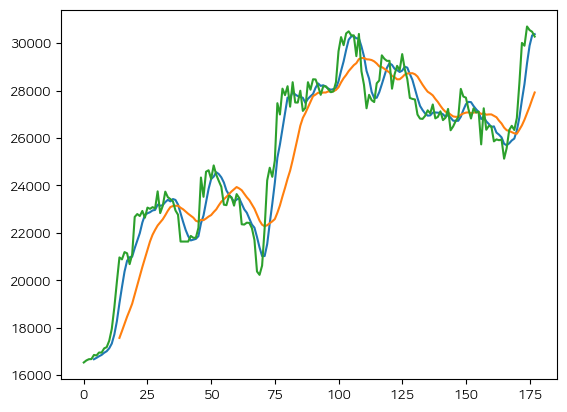

In [75]:
MAL_model(numeric_data)

numeric_data["price_open_MAL_5"].plot()
numeric_data["price_open_MAL_15"].plot()
numeric_data["price_open"].plot()

In [73]:
def MAL_model(numeric_data: pd.DataFrame):
    prices = ["price_open", "price_high", "price_low", "price_close"]
    numeric_data = prep.data

    for i in [5, 15, 30]:
        for price in prices:
            numeric_data[price + "_MAL_" + str(i)] = numeric_data[price].rolling(window=i, min_periods=i).mean()


### L3: 모델: sklearn, pytorch

### L4: 정보 취합, 규칙에 따른 트레이딩: python script

# RAW_METHOD

## UPBIT

### 초기 설정

In [19]:
access_key, jwk_secret = get_api_key("upbit")

### 전체 계좌 정보 불러오기

In [20]:
payload = { 'nonce': str(uuid.uuid4()) }
res = requests.get(generate_url("upbit", "show_account", None), headers=generate_header(payload))
res.json()

{'error': {'message': '로그인이 필요합니다.', 'name': 'no_authorization_token'}}

### 주문 가능 정보 조회

In [130]:
params = { 'market': 'KRW-BTC' }
query_string = unquote(urlencode(params, doseq=True)).encode("utf-8")

hash = hashlib.sha512()
hash.update(query_string)
query_hash = hash.hexdigest()

payload = {
    'nonce': str(uuid.uuid4()),
    'query_hash': query_hash,
    'query_hash_alg': 'SHA512',
}

res = requests.get(generate_url("upbit", "order_available", None), params=params, headers=generate_header(payload))
res.json()

{'error': {'name': 'no_authorization_ip',
  'message': 'This is not a verified IP.'}}

### 주문하기
[API docs](https://docs.upbit.com/reference/%EC%A3%BC%EB%AC%B8%ED%95%98%EA%B8%B0)

In [138]:
params = {
  'market': 'KRW-BTC', # 마켓 ID
  'side': 'bid',       # 주문 종류: ["bid": 매수, "ask": 매도]
  'ord_type': 'limit', # 주문 타입: ["limit": 지정가 주문, "price": 시장가 매수, "market": 시장가 매도]
  'price': '100.0',    # 주문 가격: KRW-BTC 마켓에서 1000 -> 1BTC당 매도 1호가가 500 KRW인 경우 2BTC가 매수됨.
  'volume': '0.01',    # 주문량
}

query_string = unquote(urlencode(params, doseq=True)).encode("utf-8")

hash = hashlib.sha512()
hash.update(query_string)
query_hash = hash.hexdigest()

payload = {
    'nonce': str(uuid.uuid4()),
    'query_hash': query_hash,
    'query_hash_alg': 'SHA512',
}

'''
200:
  uuid: 주문 고유 ID
  side: 주문 종류
  ord_type: 주문 방식
  price: 주문 당시 화폐 가격
  state: 주문 상태
  market: 마켓의 유일키
  created_at: 주문 생성 시간
  volume: 입력된 주문량
  remaining_volume: 체결 후 남은 주문 양
  reserved_fee: 수수료로 예약된 비용
  remaining_fee: 남은 수수료
  paid_fee: 지불된 수수료
  locked: 거래에 할당된 비용
  executed_volume: 체결량
  trades_count: 해당 주문에 걸린 체결 수

4XX:
  error:
    error_name: 오류 이름
    message: 오류 메시지
'''
res = requests.post(generate_url("upbit", "make_order", None), json=params, headers=generate_header(payload))
res.json()

{'error': {'name': 'no_authorization_token', 'message': '로그인이 필요합니다.'}}

## COINAPI

### 비트코인 캔들 데이터 가져오기

### 비트코인 거래량

In [21]:
import requests

query = {
    "period_id": "1HRS",
    "time_start": "2023-01-01T00:00:00",
    "time_end": "2023-01-01T23:59:59",
    "include_empty_items": "true",
}

response = requests.get(generate_url("coinapi", "BTC_candle", query=query), headers=generate_header(source="coinapi"))
response.json()

[{'time_period_start': '2023-01-01T00:00:00.0000000Z',
  'time_period_end': '2023-01-01T01:00:00.0000000Z',
  'time_open': '2023-01-01T00:00:30.1080000Z',
  'time_close': '2023-01-01T00:59:52.5600000Z',
  'price_open': 16530,
  'price_high': 16532,
  'price_low': 16507,
  'price_close': 16521,
  'volume_traded': 17.05204457,
  'trades_count': 343},
 {'time_period_start': '2023-01-01T01:00:00.0000000Z',
  'time_period_end': '2023-01-01T02:00:00.0000000Z',
  'time_open': '2023-01-01T01:02:05.8230000Z',
  'time_close': '2023-01-01T01:59:54.6410000Z',
  'price_open': 16520,
  'price_high': 16542,
  'price_low': 16519,
  'price_close': 16542,
  'volume_traded': 13.29582632,
  'trades_count': 208},
 {'time_period_start': '2023-01-01T02:00:00.0000000Z',
  'time_period_end': '2023-01-01T03:00:00.0000000Z',
  'time_open': '2023-01-01T02:00:04.6930000Z',
  'time_close': '2023-01-01T02:59:49.2110000Z',
  'price_open': 16540,
  'price_high': 16546,
  'price_low': 16532,
  'price_close': 16537,
  '

## FINANCE_DATA_READER

### 비트코인 CME 선물 가격

In [22]:
import FinanceDataReader as fdr

df = fdr.DataReader("BTC", "2023")
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,90.591003,90.618797,90.570000,90.618797,90.618797,1715.0
2023-01-04,90.879204,90.879204,90.879204,90.879204,90.879204,103.0
2023-01-05,90.751404,90.751404,90.751404,90.751404,90.751404,11.0
2023-01-06,90.919998,91.408302,90.919998,91.408302,91.408302,11299.0
2023-01-09,91.429001,91.599998,91.429001,91.599998,91.599998,3790.0
...,...,...,...,...,...,...
2023-06-14,91.459999,91.459999,91.459999,91.459999,91.459999,179.0
2023-06-15,91.824997,91.824997,91.824997,91.824997,91.824997,47.0
2023-06-16,91.614998,91.614998,91.614998,91.614998,91.614998,49.0
